# Introduction

See README.md

In [ ]:
%reset -f

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')  # default style
import tensorflow as tf
np.set_printoptions(precision=3, suppress=True)  # improve float readability
#from sklearn import datasets
from sklearn.model_selection import train_test_split
import copy
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,roc_curve,mean_squared_error,mean_absolute_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping

# Loading data

In [2]:
data_file = "./data/final_dataset_20241126.csv"
df_original = pd.read_csv(data_file, encoding='latin-1')

Mounted at /content/drive


# Data Cleaning
The initial step in data processing involved identifying and removing columns deemed non-essential or redundant for the analysis.

- **Dropped 'Unnamed: 0' column**:  
  - This column appeared to be an indexing artifact with no analytical value.

- **Removed URL and identifier columns**:  
  - Dropped the 'analysis_url,' 'track_href,' and 'uri' columns because they contained unique URLs and identifiers that were not relevant to the analysis.

- **Excluded the 'id' column**:  
  - The 'id' column was removed as it served solely as a unique identifier and did not provide meaningful insights.

- **Dropped 'search_type' column**:  
  - This column was excluded because its values consistently referred to tracks or artists and did not contribute to feature variability.

- **Removed 'type' column**:  
  - This column was dropped because it contained uniform values (e.g., 'audio_features') or missing data, making it irrelevant for the analysis.

- **Retained 'Artist' and 'Track' columns**:  
  - These columns were kept as they may provide contextual information, such as an artist’s popularity or a track's relevance, which could influence danceability predictions.

These steps were pivotal in ensuring that the dataset was optimized for analysis, containing only relevant information while minimizing noise and redundancy.

In [3]:
df_original.shape

(4600, 51)

In [4]:
df_original.columns

Index(['Unnamed: 0', 'Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity',
       'Explicit Track', 'title_artist_id', 'isrc_track_id',
       'spotify_track_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'duration_ms', 'time_signature'],
      dtype='object')

In [5]:
# Print the data types of each column
print(df_original.dtypes)

Unnamed: 0                      int64
Track                          object
Album Name                     object
Artist                         object
Release Date                   object
ISRC                           object
All Time Rank                  object
Track Score                   float64
Spotify Streams                object
Spotify Playlist Count         object
Spotify Playlist Reach         object
Spotify Popularity            float64
YouTube Views                  object
YouTube Likes                  object
TikTok Posts                   object
TikTok Likes                   object
TikTok Views                   object
YouTube Playlist Reach         object
Apple Music Playlist Count    float64
AirPlay Spins                  object
SiriusXM Spins                 object
Deezer Playlist Count         float64
Deezer Playlist Reach          object
Amazon Playlist Count         float64
Pandora Streams                object
Pandora Track Stations         object
Soundcloud S

In [6]:
# Check for missing values in each column
missing_values = df_original.isnull().sum()

# Print the number of missing values per column
print(missing_values.sort_values(ascending=False))


TIDAL Popularity              4600
isrc_track_id                 4248
Soundcloud Streams            3333
SiriusXM Spins                2123
Pandora Track Stations        1268
TikTok Posts                  1173
Pandora Streams               1106
Amazon Playlist Count         1055
YouTube Playlist Reach        1009
TikTok Views                   981
TikTok Likes                   980
Deezer Playlist Reach          928
Deezer Playlist Count          921
Spotify Popularity             804
Shazam Counts                  577
Apple Music Playlist Count     561
AirPlay Spins                  498
title_artist_id                384
YouTube Likes                  315
YouTube Views                  308
Spotify Streams                113
Spotify Playlist Reach          72
Spotify Playlist Count          70
valence                         32
acousticness                    32
instrumentalness                32
liveness                        32
duration_ms                     32
uri                 

# Data Processing
### Step 1: Handling missing values

The function  coerce_to_numeric was created to make sure objects that are meant to be numeric values are made to numeric. This will allow for subsequent handing of missing values using averages and modelling.

In [7]:
# Make columns into int values
def coerce_to_numeric(list_of_columns):
    '''
    Checks the data type of the columns passed against the original dataset
      Args:
      list_of_columns: a list of columns to be checked

      Returns:
       List of columns that have not successfully been coerced
    '''
    non_successful_list=[]
    for col in list_of_columns:
        try:
            #df_original[col] = df_original[col].str.replace(',', '').astype('float64')
            if df_original[col].dtype not in ['int64', 'float64']:
                df_original[col] = df_original[col].astype(str).str.replace(',', '', regex=False)
                df_original[col] = df_original[col].astype(str).str.replace('nan', '0', regex=False)
                df_original[col]  = df_original[col].fillna(0)
                df_original[col] = df_original[col].astype(int)
        except Exception as e:
            non_successful_list.append(col)
    return non_successful_list

### Step 2: Determine columns to drop

This step includes iterative checking of non-conformant data which is subsequently dropped to ensure successful running of models.

It starts of by checking all original columns and attempting to coerce them to numeric using the _coerce_to_numeric_ function.

The next step, it checks all columns that are non-numeric and adds them to the list for processing containing columns for dropping.

Lastly the columns are dropped from the original data set

In [8]:
# Check the values for each column to be dropped
for i in df_original.columns:
    print(df_original[i].head(5))

0    0
1    1
2    2
3    3
4    4
Name: Unnamed: 0, dtype: int64
0           MILLION DOLLAR BABY
1                   Not Like Us
2    i like the way you kiss me
3                       Flowers
4                       Houdini
Name: Track, dtype: object
0    Million Dollar Baby - Single
1                     Not Like Us
2      I like the way you kiss me
3                Flowers - Single
4                         Houdini
Name: Album Name, dtype: object
0     Tommy Richman
1    Kendrick Lamar
2           Artemas
3       Miley Cyrus
4            Eminem
Name: Artist, dtype: object
0    4/26/2024
1     5/4/2024
2    3/19/2024
3    1/12/2023
4    5/31/2024
Name: Release Date, dtype: object
0    QM24S2402528
1    USUG12400910
2    QZJ842400387
3    USSM12209777
4    USUG12403398
Name: ISRC, dtype: object
0    1
1    2
2    3
3    4
4    5
Name: All Time Rank, dtype: object
0    725.4
1    545.9
2    538.4
3    444.9
4    423.3
Name: Track Score, dtype: float64
0      390,470,936
1      323,703

In [9]:
# Try to coerce the columns to numeric where possible.
# The functions returns the columns that failed

columns_for_processing=coerce_to_numeric(missing_values.index.to_list())
columns_for_processing

['Track',
 'Album Name',
 'Artist',
 'Release Date',
 'ISRC',
 'title_artist_id',
 'isrc_track_id',
 'spotify_track_id',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url']

In [10]:
# Check for other non float and non int columnd for removal
for i in df_original.columns:
    if df_original[i].dtype==object:
        if i not in columns_for_processing:
            columns_for_processing.append(i)

columns_for_processing

['Track',
 'Album Name',
 'Artist',
 'Release Date',
 'ISRC',
 'title_artist_id',
 'isrc_track_id',
 'spotify_track_id',
 'type',
 'id',
 'uri',
 'track_href',
 'analysis_url']

In [11]:
# Drop the columns with missing values above that could not be coerced into float
df_original = df_original.drop(columns_for_processing,axis=1)

### Step 3: Filling in missing values

One more check for missing values was done.

Then the column means was used to fill in the missing values for each column.

TIDAL column was dropped because all values in this column were missing.

In [12]:
# Check for missing values in each column
missing_values = df_original.isnull().sum()

# Print the number of missing values per column
print(missing_values.sort_values(ascending=False))

TIDAL Popularity              4600
Amazon Playlist Count         1055
Deezer Playlist Count          921
Spotify Popularity             804
Apple Music Playlist Count     561
time_signature                  32
loudness                        32
danceability                    32
energy                          32
key                             32
mode                            32
speechiness                     32
acousticness                    32
instrumentalness                32
liveness                        32
valence                         32
tempo                           32
duration_ms                     32
Soundcloud Streams               0
Explicit Track                   0
Shazam Counts                    0
Unnamed: 0                       0
Pandora Track Stations           0
All Time Rank                    0
Deezer Playlist Reach            0
SiriusXM Spins                   0
AirPlay Spins                    0
YouTube Playlist Reach           0
TikTok Views        

In [13]:
# Drop tidal popularity
df_original = df_original.drop(['TIDAL Popularity'],axis=1)

In [15]:
# Check numeric columns
numeric_cols = df_original.select_dtypes(include=['int64', 'float64']).columns
numeric_cols

Index(['Unnamed: 0', 'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'Explicit Track', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'time_signature'],
      dtype='object')

In [16]:
### “Filling” of null data with average for numeric values
column_means = df_original[numeric_cols].mean()
df_original.fillna(column_means,inplace=True)


### Step 4: Dropping Duplicates

Duplicates were dropped using the 'Unnamed: 0' column, which was a unique identifier

A further check to confirm there were no non-numeric columns was done

In [17]:
# Drop Duplicates based on 'Unnamed: 0'
df_original = df_original.drop_duplicates(subset='Unnamed: 0', keep='first')

In [18]:
# Check shape
df_original.shape

(4600, 37)

In [19]:
# Drop non-numeric columns except Artist
# We shall creating one hot encoding based on artist later
original_cols=df_original.columns
non_numeric_cols= [x for x in original_cols if x not in numeric_cols]
non_numeric_cols

[]

### Step 5: Checking the heat map for correlation

The heatmap was plotted and used to

1) Check on correlation of the different columns

2) Feature engineering to reduce dimensionality and improve model performance.

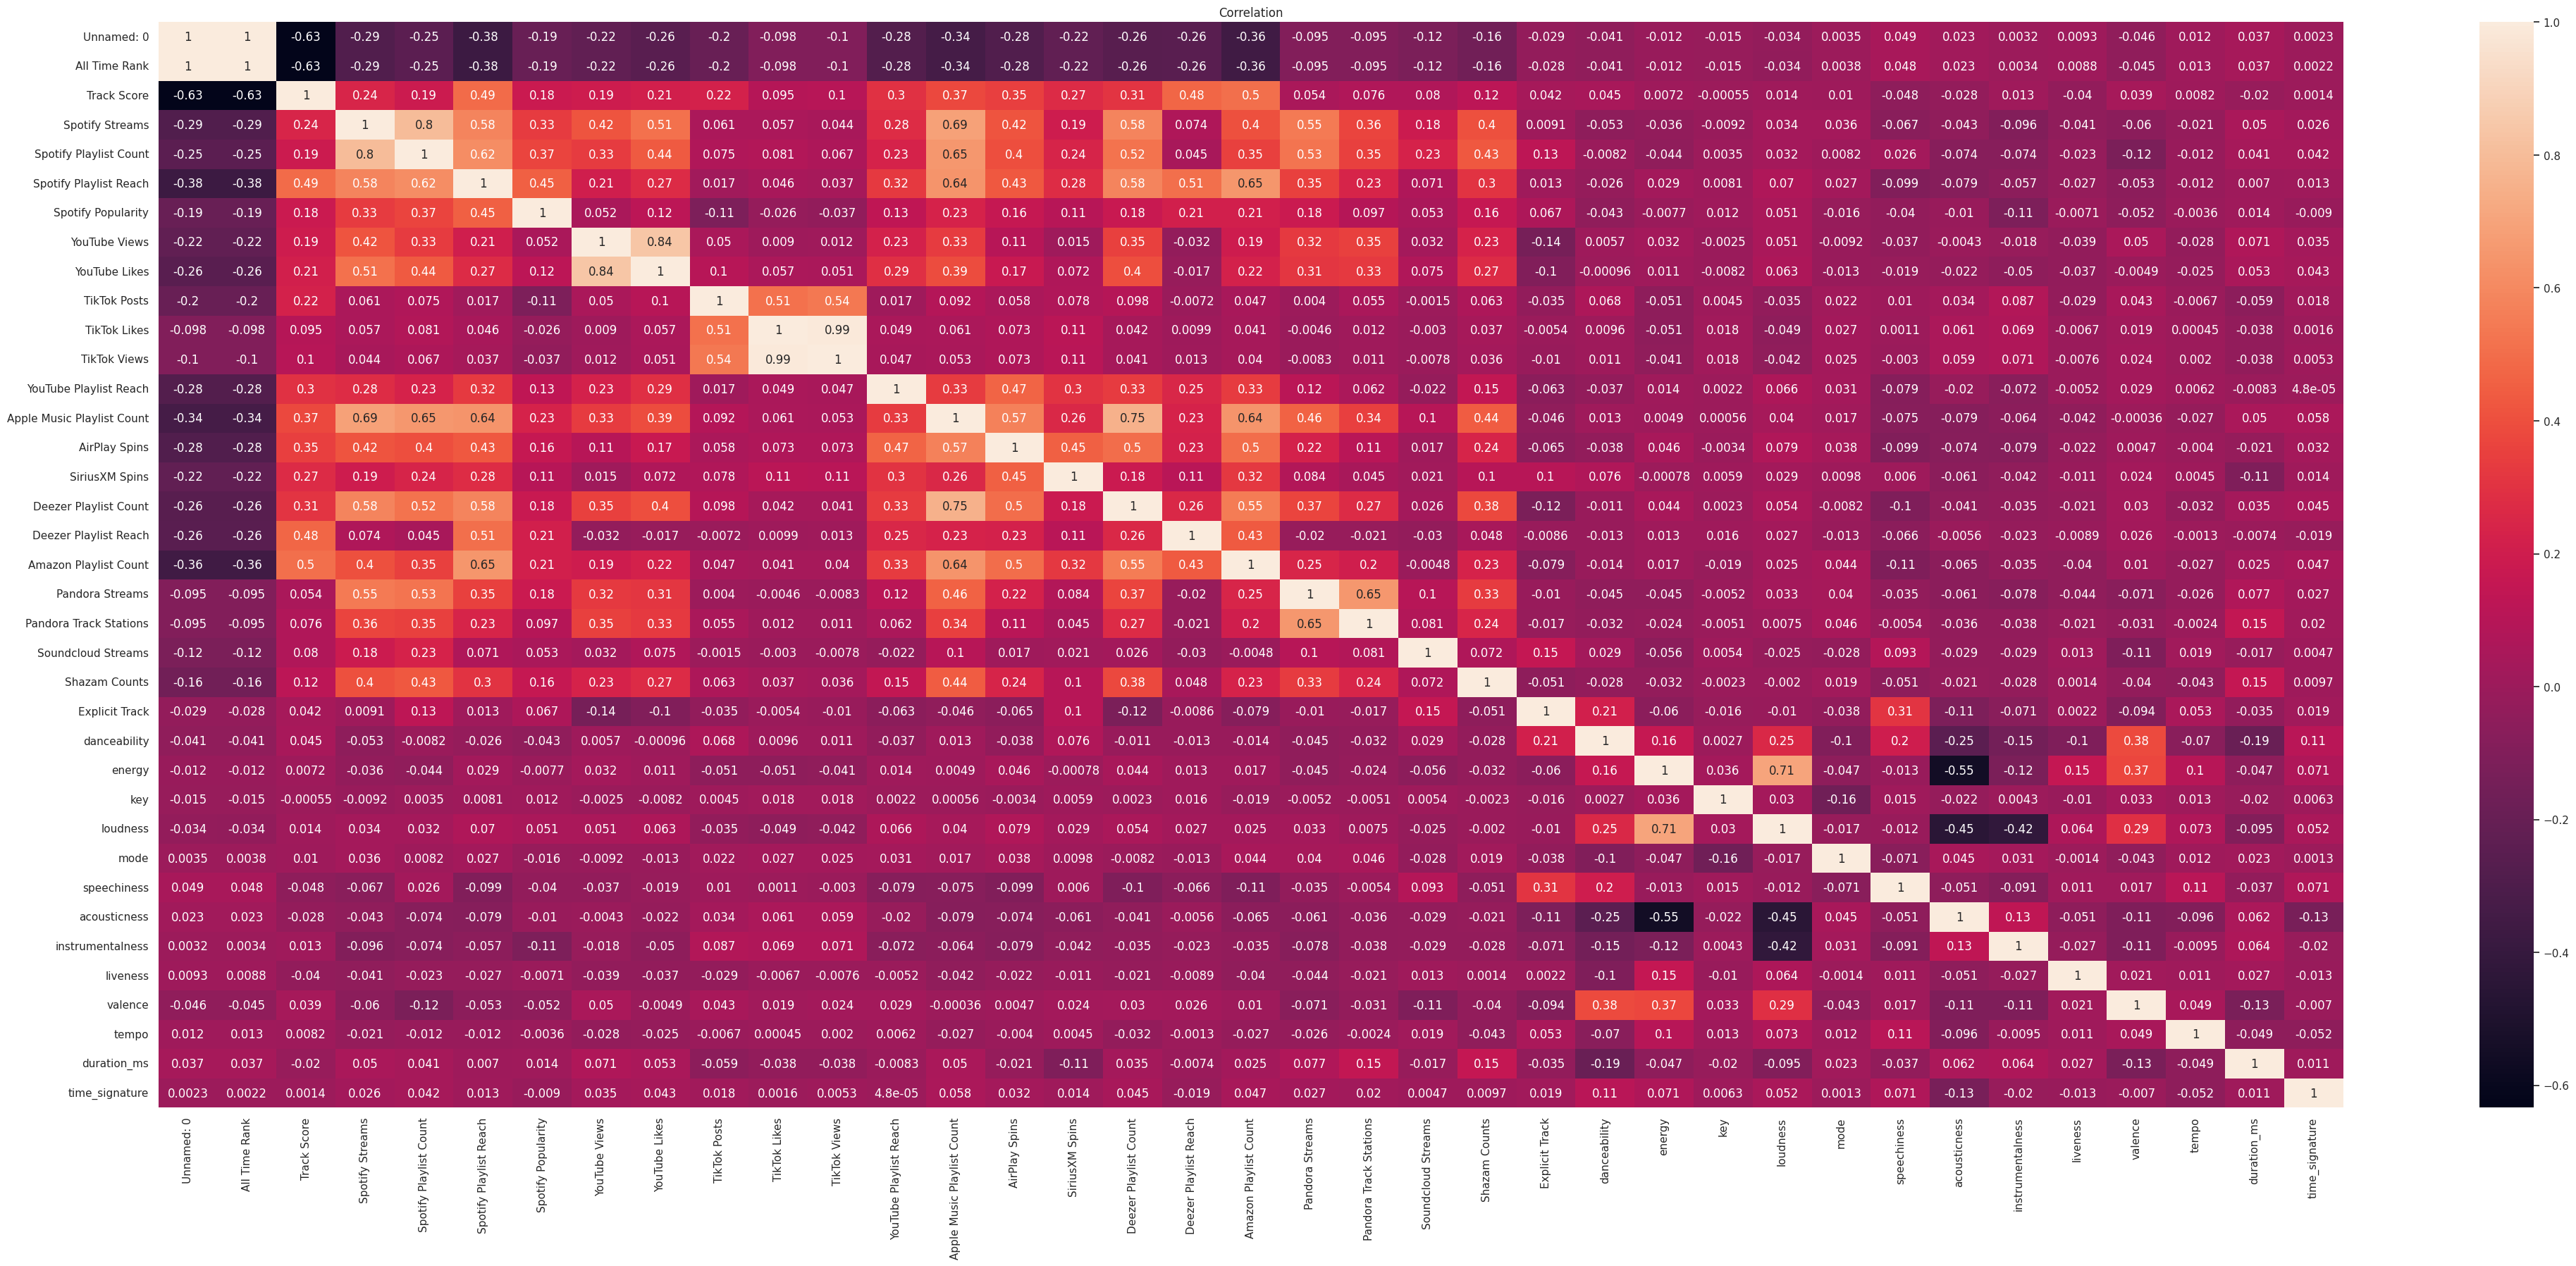

In [20]:
# Check heatmap

corr_matrix = df_original[numeric_cols].corr()

# Create a heatmap
plt.figure(figsize=(50, 20))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation')
plt.show()

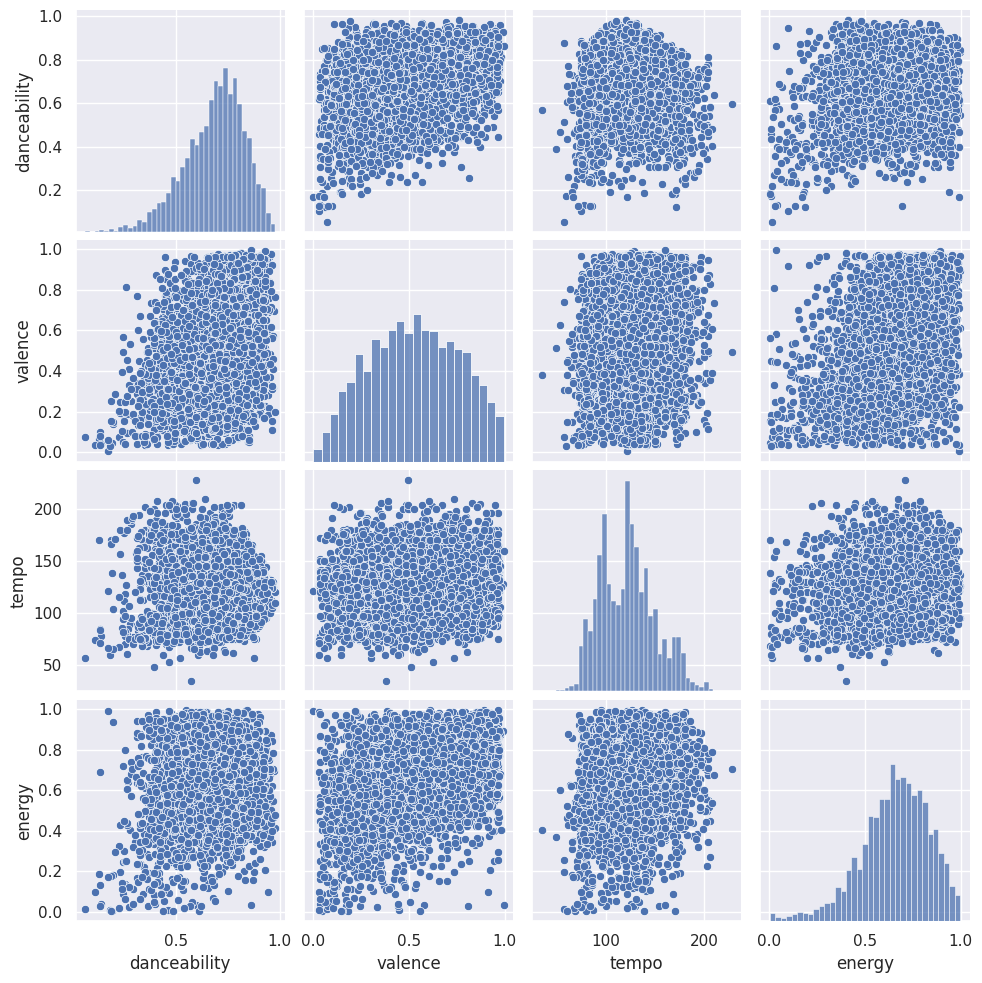

In [25]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# Example: 'dv' is the dependent variable
features = ['danceability','valence', 'tempo', 'energy',]

sns.pairplot(df_original, x_vars=features, y_vars=features, kind='scatter')
plt.show()

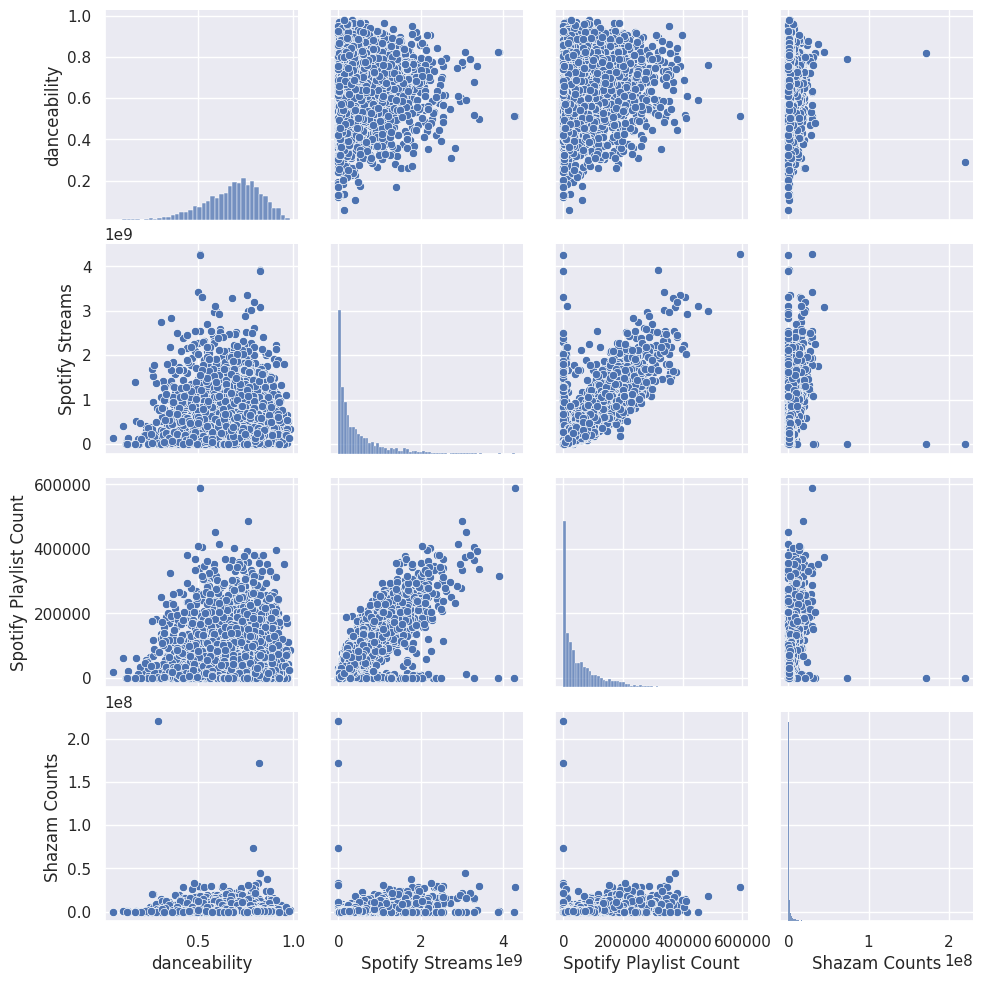

In [26]:

import matplotlib.pyplot as plt
import seaborn as sns

# Example: 'dv' is the dependent variable
features = ['danceability','Spotify Streams', 'Spotify Playlist Count','Shazam Counts']

sns.pairplot(df_original, x_vars=features, y_vars=features, kind='scatter')
plt.show()

# Categorization of the Outcome Variable

- **Danceability Classification**:
  - A function, `danceability_classifier`, was defined to classify the danceability feature into multi-class values:
    - 0 for very low danceability (if danceability < 0.4).
    - 1 for low danceability (if 0.4 ≤ danceability < 0.7).
    - 2 for medium danceability (if 0.7 ≤ danceability < 0.9).
    - 3 for high danceability (if danceability ≥ 0.9).

- **Binary Danceability Column Creation**:
  - A new column, `binary_danceability`, was created by applying the `danceability_classifier` function to the `danceability` feature.

- **Target and Feature Extraction**:
  - Extracted `binary_danceability` as the target variable (Y) for modeling.
  - Retained other processed features (X) for modeling but removed the original `danceability` and `binary_danceability` columns from the features.

- **Shape Verification**:
  - Verified the shapes of the features (X) and the target variable (Y):
    - X: (4600, 37) features, after including the newly created binary column.
    - Y: (4600, 1) target labels.

- **Data Shuffling**:
  - Shuffled the dataset to ensure randomness using NumPy's shuffle method with a predefined seed (`1234`) for reproducibility.

In [21]:
def danceability_classifier(x):
    '''
      Classifies the danceability param to either 1-low, 2-medium or 3-High
      Args:
      x: input decimal denoting deacneabiluty

      Returns:
       Either of the int values in 1,2,3 representing 1-low, 2-medium or 3-High

    '''
    if x >= 0.9:
        return 3
    elif 0.7 <= x  <0.9:
        return 2
    elif 0.4 <= x  <0.7:
        return 1
    else:
        return 0

In [22]:
# Creating a deep copy for model use

df = copy.deepcopy(df_original)

In [23]:
# Categorise the data set as Either danceable or not

df['binary_danceability'] = df['danceability'].apply(danceability_classifier)


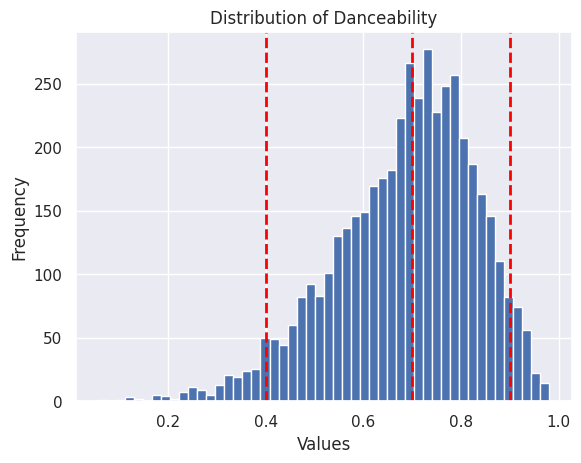

In [24]:
df['danceability'].plot.hist(bins=50)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Danceability')

# Add vertical lines
for x in [0.4, 0.7, 0.9]:
    plt.axvline(x=x, color='red', linestyle='--', linewidth=2)

plt.show()

In [ ]:
# Get the features and outcome variables separated for the onehot encoded dataset
Y=pd.DataFrame(df['binary_danceability'])
df.drop(['binary_danceability','danceability'],axis=1,inplace=True)
X=pd.DataFrame(df)

In [ ]:
Y.head()

,binary_danceability
0,2
1,2
2,1
3,2
4,3


In [ ]:
df_original['danceability'].median

<bound method Series.median of 0       0.852
1       0.898
2       0.599
3       0.706
4       0.936
        ...  
4595    0.844
4596    0.574
4597    0.824
4598    0.799
4599    0.808
Name: danceability, Length: 4600, dtype: float64>

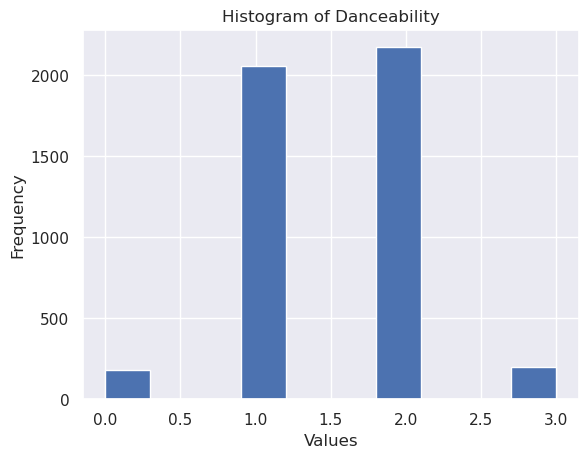

In [ ]:
# Create the histogram for the Y column
plt.hist(Y)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Danceability')
plt.show()

In [ ]:
X.head()

,Unnamed: 0,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,Spotify Popularity,YouTube Views,YouTube Likes,TikTok Posts,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,1,725.4,390470936,30716,196631588,92.0,84274754,1713126,5767700,...,-5.520,0.0,0.0439,0.097300,0.000370,0.0678,0.919,138.029,155152.0,4.0
1,1,2,545.9,323703884,28113,174597137,92.0,116347040,3486739,674700,...,-7.001,1.0,0.0776,0.010700,0.000000,0.1410,0.214,101.061,274192.0,4.0
2,2,3,538.4,601309283,54331,211607669,92.0,122599116,2228730,3025400,...,-4.263,1.0,0.0447,0.000938,0.010600,0.0826,0.747,151.647,142515.0,4.0
3,3,4,444.9,2031280633,269802,136569078,85.0,1096100899,10629796,7189811,...,-4.775,1.0,0.0633,0.058400,0.000070,0.0232,0.632,118.048,200600.0,4.0
4,4,5,423.3,107034922,7223,151469874,88.0,77373957,3670188,16400,...,-2.760,0.0,0.0683,0.029200,0.000002,0.0582,0.889,127.003,227239.0,4.0


In [ ]:
print("X shape:", X.shape,"Y shape:",Y.shape)

X shape: (4600, 36) Y shape: (4600, 1)


In [ ]:
# Convert to numpy array
X=np.array(X)
Y=np.array(Y)

In [ ]:
# Shuffle data
# NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
tf.random.set_seed(1234)
np.random.seed(1234)

# shuffle data
indices = np.arange(Y.shape[0])
np.random.shuffle(indices)

# Re-order using the list of shuffled indices
X = X[indices]
Y = Y[indices]

- **Train-Test-Validation Split**:
  - The dataset was split into training, validation, and test sets:
    - **Initial Split**: 60% training and 40% test data using `train_test_split` with a fixed `random_state=1234`.
    - **Further Split**: The test data was further divided into 20% training and 20% validation sets.
      - **Training Set**: 2,944 samples with 37 features each.
      - **Validation Set**: 920 samples with 37 features each.
      - **Test Set**: 920 samples with 37 features each.

In [ ]:
# Split the (X,Y) data into training and test paritions

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=1234)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=1234)

# EX2.2
# Print the shape of each array.
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: (2760, 36)
X_test shape: (920, 36)
X_val shape: (920, 36)
Y_train shape: (2760, 1)
Y_test shape: (920, 1)
Y_val shape: (920, 1)


# Baseline Model

- **Energy-to-Danceability Baseline**:
  - Introduced a simple baseline assuming a direct correlation between energy and danceability.
  - **Binning Process**:
    - Both `energy` and `danceability` values were binned into four categories based on thresholds:
      - Bin 0: Very low (0.0 to 0.4).
      - Bin 1: Low (0.4 to 0.7).
      - Bin 2: Medium (0.7 to 0.9).
      - Bin 3: High (0.9 to 1.0).
    - Created new columns: `energy_binned_value` and `danceability_binned_value` to represent the binned values.

- **Accuracy Calculation**:
  - Compared `energy_binned_value` and `danceability_binned_value` to calculate baseline accuracy.
  - **Results**:
    - Baseline accuracy: **41.97%**, showing the limitations of assuming a simple direct correlation between energy and danceability.

In [ ]:
# Baseline value assumes that danceable songs are energetic
# Therefore this baseline is when it is assumed that energy has a direct correlation to danceability

# Define bin edges similar to danceability classifier
bins = [0, 0.4, 0.7, 0.90, 1]
df_original['energy_binned_value'] = pd.cut(df_original['energy'], bins=bins, labels=False)
df_original['danceability_binned_value'] = pd.cut(df_original['danceability'], bins=bins, labels=False)

# Count occurrences of each bin
energy_bin_counts = df_original['energy_binned_value'].value_counts().sort_index()
danceability_bin_counts = df_original['danceability_binned_value'].value_counts().sort_index()

print(energy_bin_counts)
print(danceability_bin_counts)


# Calculate accuracy
accuracy = (df_original['energy_binned_value'] == df_original['danceability_binned_value']).mean()

print("\n Baseline accuracy:", accuracy)

energy_binned_value
0     384
1    2235
2    1682
3     299
Name: count, dtype: int64
danceability_binned_value
0     186
1    2058
2    2164
3     192
Name: count, dtype: int64

 Baseline accuracy: 0.41978260869565215


# Advanced Models

Given the outcome variable has been binned, it is presented as a multi-classifier problem.

Four models were chosen to address the regression problem:
 - Logistic regression
 - HistGradient Booster
 - Neural Network
 - Random Forest





**Validation function:**
This function was created to calculate model perfomance on validation data uniformly for all the models chosen

**Prediction function:**
This function was created to calculate model perfomance on test data uniformly for all the models chosen

In [ ]:
def train_validation_scores(model,model_type=''):
    '''
    Runs models predictions, and calculates model performance metrics on train and validation data sets
      Args:
      model: the model to be evaluated

    '''
      # Evaluate the model on test data
    y_train_pred = model.predict(X_train)
    if model_type == 'neuralnet':
      y_train_pred = np.argmax(y_train_pred, axis=1)
      accuracy = accuracy_score(y_train_pred, Y_train)
    else:
      accuracy = accuracy_score(y_train_pred, Y_train_ravel)

    mse=np.mean((Y_train_ravel - y_train_pred)**2)

    print("### Test data evaluation: \n")
    print("Train Accuracy:", accuracy,"\n")
    print("Train MSE:", mse,"\n")

    # Evaluate the model on validation data set
    y_pred = model.predict(X_val)
    if model_type == 'neuralnet':
      y_pred = np.argmax(y_pred, axis=1)
      accuracy = accuracy_score(y_pred, Y_val)
    else:
      accuracy = accuracy_score(y_pred, Y_val)
    mse=np.mean((Y_val - y_pred)**2)

    print("### Validation data evaluation: \n")
    print("Validation Accuracy:", accuracy,"\n")
    print("Validation MSE:", mse,"\n")

In [ ]:
# Make predictions on validation set
def prediction_scores(model,model_type=''):
    '''
    Runs models predictions, calculates model performance metrics and plots confusion matrix
      Args:
      model: the model to be evaluated

    '''

    # Make predictions on test data set
    y_pred_test = model.predict(X_test)

    # Evaluate the model on test data
    if model_type == 'neuralnet':
      y_pred_test = np.argmax(y_pred_test, axis=1)
      accuracy = accuracy_score(y_pred_test, Y_test)
    else:
      accuracy = accuracy_score(y_pred_test, Y_test)
    mse =  mean_squared_error(y_pred_test, Y_test)
    precision = precision_score(y_pred_test, Y_test, average=None, zero_division=0)
    recall = recall_score(y_pred_test, Y_test, average=None,zero_division=0)
    f1 = f1_score(y_pred_test, Y_test, average=None)
    mae = mean_absolute_error(y_pred_test, Y_test)


    print("\n### Test data set evaluation: \n")
    print("Accuracy:", accuracy,"\n")
    print("Mean Squared Error (MSE):", mse,"\n")
    print("Mean Absolute Error (MAE):", mae,"\n")
    print("Precision:", precision,"\n")
    print("Recall:", recall,"\n")
    print("F1 Score:", f1,"\n")

    # Plot the confusion matrix for test data
    # Create the confusion matrix
    cm = confusion_matrix(Y_test, y_pred_test)

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    plt.show()



In [ ]:
# Convert outcome variable Y into 1D array
Y_train_ravel=Y_train.ravel()
Y_val_ravel=Y_val.ravel()
Y_test_ravel=Y_test.ravel()

### Scikit-Learn Logistic Regression Model

- **Model Selection**:
  - Chose a scikit-learn `LogisticRegression` as the model for this iteration, leveraging its simplicity and ability to handle numerical data efficiently.

- **Training the Model**:
  - Trained the `LogisticRegression` using the prepared training data (`X_train`, `Y_train`).

- **Validation Predictions**:
  - Made predictions on the validation set (`X_val`) of  the trained model using the custom `validation_score` function.

- **Performance Evaluation**:
    - Calculated the validation accuracy using scikit-learn's `accuracy_score` function within the custom `prediction_score` function.

- **Results**:

  | Parameters    | Train-Accuracy | Validation-Accuracy | Test-Accuracy |
  | -------- | ------- | ------- | ------- |
  | max_iter=5000, multi_class='multinomial', solver='lbfgs' | 49.92%    | 46.30%    |49.23%
  | max_iter=500, multi_class='multinomial', solver='lbfgs'  | 49.74%    | 45.86%    |44.23%
  | max_iter=500, solver='liblinear' | 50.14%     |47.93%  |48.69%
  | max_iter=5000, solver='liblinear' | 50.14%     |47.93%  |48.69%
  | max_iter=5000, multi_class='multinomial', solver='saga' | 50.43%     |47.5%  |48.80%
  | max_iter=500, multi_class='multinomial', solver='saga' | 51.159%     |45.869%  |50.32%


- **Observations**:
  - It was noted that the model did not reach convergence with solver lbfgs in any iteration, and for solver saga convergence was not reached for under 1000
  - The model had a modest performance that is higher than the baseline but it was not optimal

In [ ]:
# LOGISTIC REGRESSION
from sklearn.preprocessing import StandardScaler

# # Scale the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Create the model
model = LogisticRegression(max_iter=5000, multi_class='multinomial', solver='saga')

# Train the model
model.fit(X_train, Y_train_ravel)

train_validation_scores(model)



### Test data evaluation: 

Train Accuracy: 0.5043478260869565 

Train MSE: 0.6195652173913043 

### Validation data evaluation: 

Validation Accuracy: 0.475 

Validation MSE: 0.6782396030245746 




### Test data set evaluation: 

Accuracy: 0.5032608695652174 

Mean Squared Error (MSE): 0.6369565217391304 

Mean Absolute Error (MAE): 0.5434782608695652 

Precision: [0.    0.428 0.675 0.   ] 

Recall: [0.    0.513 0.498 0.   ] 

F1 Score: [0.    0.467 0.573 0.   ] 



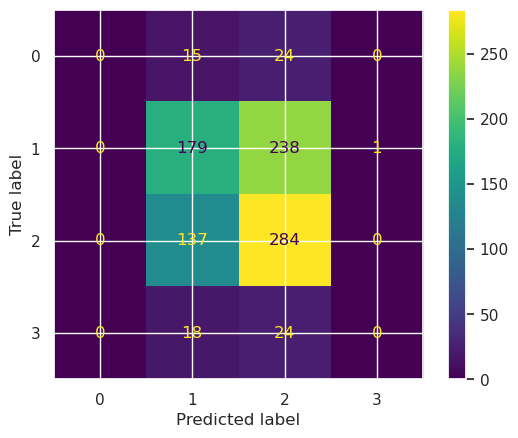

In [ ]:
#Run the model on test data
prediction_scores(model)

### Scikit-Learn HistGradientBoostingClassifier Model

- **Model Selection**:
  - Chose a scikit-learn `HistGradientBoostingClassifier` as the model for this iteration, leveraging its ability to handle more complex numerical data efficiently.

- **Training the Model**:
  - Filled missing values in `X_train` with zeros to ensure compatibility with the model.
  - Trained the `HistGradientBoostingClassifier` using the prepared training data (`X_train`, `Y_train`).

- **Validation Predictions**:
  - Made predictions on the validation set (`X_val`) of  the trained model using the custom `validation_score` function.

- **Performance Evaluation**:
  - Calculated the validation accuracy using scikit-learn's `accuracy_score` function within the custom `prediction_score` function.

- **Results**:

  | Parameters    | Train-Accuracy | Validation-Accuracy | Test-Accuracy |
  | -------- | ------- | ------- | ------- |
  | learning_rate=0.001, max_iter=20, max_leaf_nodes=30  | 48.40%    | 44.89%    |45.76%
  | learning_rate=0.001, max_iter=100, max_leaf_nodes=30  | 69.34%    | 62.28%    |61.19%
  | learning_rate=0.001, max_iter=100, max_leaf_nodes=30 | 69.34%     |62.28%  |60.32%
  | learning_rate=0.001, max_iter=100, max_leaf_nodes=10 | 62.46%     |58.478%  |57.93%
  | learning_rate=0.1, max_iter=100, max_leaf_nodes=30 | 100%     |67.17%  |66.84%
  | learning_rate=0.01, max_iter=100, max_leaf_nodes=30 | 83.62%     |66.63%  |66.08%
  | learning_rate=0.01, max_iter=500, max_leaf_nodes=30 | 99.45%     |66.95%  |67.39%
  | learning_rate=0.001, max_iter=500, max_leaf_nodes=50 | 100%     |66.08%  |67.60%
  | learning_rate=0.001, max_iter=100, max_leaf_nodes=50 | 73.11%     |62.71%  |60.32%


- **Observations**:  
  - By looking at the F score values, the model was mostly predicting the dominant outputs due to outcome variable invariance
  - The model is prone to overfitting being a decision tree and gaining a balance with the paramter tuning was difficult

In [ ]:

# HistGradientBoostingClassifier

# Create the model
model = HistGradientBoostingClassifier(learning_rate=0.001, max_iter=100, max_leaf_nodes=30)

# Train the model
model.fit(X_train, Y_train_ravel)

# Print the evaluation metrics
train_validation_scores(model)


### Test data evaluation: 

Train Accuracy: 0.6934782608695652 

Train MSE: 0.3391304347826087 

### Validation data evaluation: 

Validation Accuracy: 0.6228260869565218 

Validation MSE: 0.6768643667296786 




### Test data set evaluation: 

Accuracy: 0.6032608695652174 

Mean Squared Error (MSE): 0.4260869565217391 

Mean Absolute Error (MAE): 0.40652173913043477 

Precision: [0.    0.416 0.905 0.   ] 

Recall: [0.    0.707 0.565 0.   ] 

F1 Score: [0.    0.524 0.696 0.   ] 



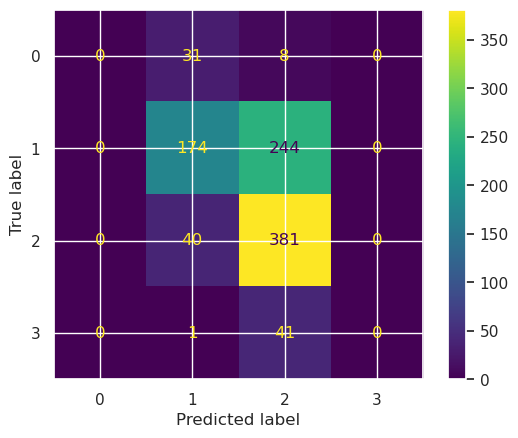

In [ ]:
prediction_scores(model)

### Random Forest

- **Model Setup**:
  - Utilized scikit-learn's `RandomForestClassifier` with the following key parameters:
    - `n_estimators`: number of decision trees in the forest.
    - `max_depth`: maximum depth of each tree.
    - `bootstrap`: False (sampling without replacement).
    - `random_state`: 0 (to ensure reproducibility).

- **Training the Model**:
  - Trained the random forest model using the training data (`X_train`, `Y_train`).

- **Performance Evaluation**:
  - Evaluated the model's performance on the training, validation, and test sets:
  
  | Parameters    | Train-Accuracy | Validation-Accuracy | Test-Accuracy |
  | -------- | ------- | ------- | ------- |
  | n_estimators=20, max_depth=5,  | 71.4%    | 64.565%    |60.76%
  | n_estimators=50, max_depth=10, | 71.70%     |65%  |61.30%
  | n_estimators=100, max_depth=5, | 72.53%     |65.43%  |62.06%
  | n_estimators=100, max_depth=10, | 92.97%     |65.10%  |65.43%
  | n_estimators=100, max_depth=20, | 100%     |65.54%  |66.52%
  | n_estimators=150, max_depth=10, | 92.78%     |65.32%  |66.08%
  


- **Confusion Matrices**:
  - Generated confusion matrices to assess the distribution of predicted versus actual classes:
    - Displayed a heatmap for the validation set confusion matrix.
    - Provided a confusion matrix for the test set to visualize performance.

- **Observations**:
  - The random forest model achieved similar accuracy to previous models, indicating room for improvement in feature engineering or model tuning.
  - Random forest and decision trees are prone to overfitting hence a balance needs to be achieved to ensure generizability

In [ ]:
# Random Forest
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=10, random_state=0,bootstrap=False)

# Train the model
model.fit(X_train, Y_train_ravel)

# Make predictions on the train-validation set
train_validation_scores(model)


### Test data evaluation: 

Train Accuracy: 0.7253623188405797 

Train MSE: 0.2876811594202899 

### Validation data evaluation: 

Validation Accuracy: 0.6543478260869565 

Validation MSE: 0.6900685255198488 




### Test data set evaluation: 

Accuracy: 0.6206521739130435 

Mean Squared Error (MSE): 0.38913043478260867 

Mean Absolute Error (MAE): 0.3826086956521739 

Precision: [0.051 0.533 0.822 0.   ] 

Recall: [0.333 0.668 0.597 0.   ] 

F1 Score: [0.089 0.593 0.691 0.   ] 



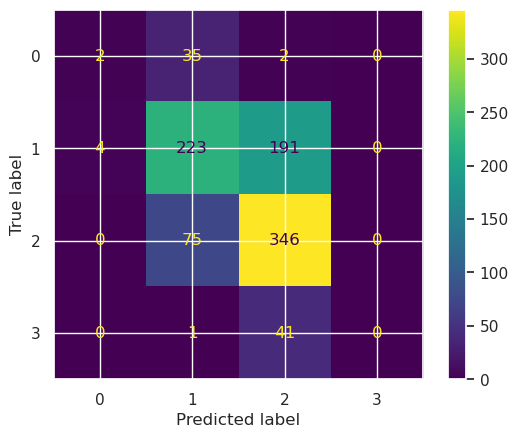

In [ ]:
prediction_scores(model)

### Neural Network

- **Model Architecture**:
  - Built a neural network using TensorFlow's Keras API with the variable layers for experimentaion
  - Optimizer: Used both Adam and SGD for comparison of performance.
  - Loss function: Categorical Crossentropy.
  - Metrics: Accuracy, MSE and MAE

- **Training**:
  - Converted the training and validation datasets (`X_train`, `X_val`) to TensorFlow tensors.
  - Converted the outcome variable into a one encoded variable to match the required output units

- **Performance Results**:
    | Parameters    | Train-Accuracy | Validation-Accuracy | Test-Accuracy |
    | -------- | ------- | ------- | ------- |
    | epochs=5, batch_size=128, learning_rate=0.01, hidden layers=1, optimizer=Adam  |43.77  | 45.98%    |45.43%
    | epochs=5, batch_size=16, learning_rate=0.01, hidden layers=1, optimizer=Adam  | 48.40%     |44.89%  |45.76%
    | epochs=5, batch_size=16, learning_rate=0.0001, hidden layers=1, optimizer=Adam  | 43.87%     |45.92%  |45.43%
    | epochs=50, batch_size=16, learning_rate=0.01, hidden layers=3, optimizer=Adam | 33.91%     |35%  |35.54%
    | epochs=5, batch_size=128, learning_rate=0.0001, hidden layers=30, optimizer=Adam | 43.8%     |45.86%  |45.54%
    | epochs=50, batch_size=128, learning_rate=0.0001, hidden layers=30, optimizer=Adam | 48.44%     |48.69%  |49.89%
    | epochs=50, batch_size=128, learning_rate=0.0001, hidden layers=40, optimizer=Adam | 44.27%     |46.41%  |43.69%
    | epochs=50, batch_size=128, learning_rate=0.0001, hidden layers=15, optimizer=Adam | 47.17%     |44.02%  |44.02%
    | epochs=50, batch_size=16, learning_rate=0.01, hidden layers=30, optimizer=Adam | 48.40%     |44.89%  |45.76%
    | epochs=50, batch_size=64, learning_rate=0.01, hidden layers=30, optimizer=SGD | 3.840%     |3.913%  |4.239%
    | epochs=50, batch_size=128, learning_rate=0.01, hidden layers=30, optimizer=SGD | 48.40%     |44.89%  |45.76%
    | epochs=50, batch_size=128, learning_rate=0.0001, hidden layers=30, optimizer=SGD | 3.840%     |3.91%  |4.239%
    | epochs=50, batch_size=128, learning_rate=0.0001, hidden layers=30, optimizer=Adam | 48.91%     |45.32%  |46.95%

- **Observations**:
  - The model had overall poor performance, which was unexpected
  - After several iterations Adam optimizer proved to have better results and a high number of hidden layers was suitable
  - It was concluded that the data was too small, and there was overdimensionality that caused the Neural Network to perform poorly
  - Additionally the unbalanced outcome variable caused the models to predict the central majority values due to under-representation of the outliers. Thus the outcome variable boundaries need to be re-evaluated.

In [ ]:
from tensorflow.keras.layers import Input
def build_model(num_features, learning_rate):
  """Build a TF linear regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate.

  Returns:
    model: A tf.keras model (graph).
  """

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  input_layer = Input(shape=(num_features,))
  model = tf.keras.Sequential([input_layer])
  model.add(tf.keras.layers.Dense(
      units=64,                   # output dim
      use_bias=False,              # use a bias (intercept) param
      activation='relu',          # activation functions
      kernel_initializer='Ones',  # initialize params to 1
      bias_initializer='Ones',    # initialize bias to 1 if true
  ))

  # For tuning hidden layers
  units_layers=[64,32,16]
  hidden_layers=[10,10,10]
  for i in units_layers:
    for j in range(0,hidden_layers[units_layers.index(i)]):
      model.add(tf.keras.layers.Dense(units=i, activation='relu'))

  model.add(tf.keras.layers.Dense(units=4, activation='softmax'))

  # We need to choose an optimizer.
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile( optimizer=optimizer, metrics=['accuracy'], loss='categorical_crossentropy')

  return model

In [ ]:
#tf.random.set_seed(0)
# 2. Build and compile model
num_features = X_train.shape[1]
learning_rate = 0.0001
epochs=50
num_classes=4
batch_size=128

# Build the model
model=build_model(num_features, learning_rate)

#Convert multiclass to one hot for multi class
Y_train_onehot = np.eye(num_classes)[Y_train.flatten()]
Y_val_onehot = np.eye(num_classes)[Y_val.flatten()]
#Y_test_onehot = np.eye(num_classes)[Y_test.flatten()]

# 3. Fit the model
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
results=model.fit(X_train, Y_train_onehot, batch_size=batch_size,epochs=epochs, validation_data=(X_val, Y_val_onehot), verbose=True, callbacks=[early_stop])

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4755 - loss: 10499.2158 - val_accuracy: 0.4489 - val_loss: 1027.6644
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4610 - loss: 2178.9792 - val_accuracy: 0.4598 - val_loss: 971.7689
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4612 - loss: 1639.3849 - val_accuracy: 0.4685 - val_loss: 469.4486
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4821 - loss: 1240.7891 - val_accuracy: 0.4598 - val_loss: 629.9044
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4560 - loss: 1113.0291 - val_accuracy: 0.4587 - val_loss: 396.3926
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4594 - loss: 930.0312 - val_accuracy: 0.4598 - val_loss: 541.6981
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4563 - loss: 938.4278 - val_accuracy: 0.4598 - val_loss: 453.8253
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4333 - loss: 686.2

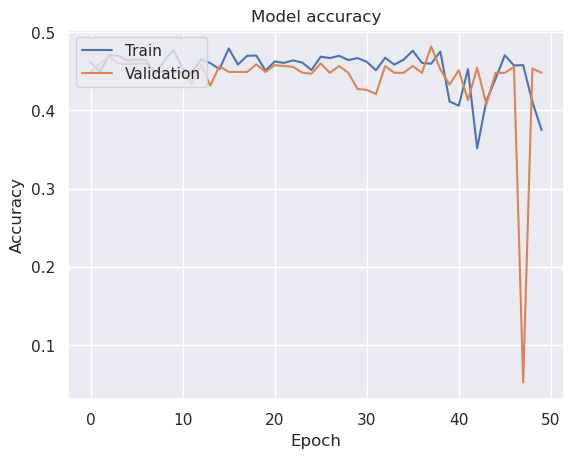

In [ ]:
# Plot training history

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



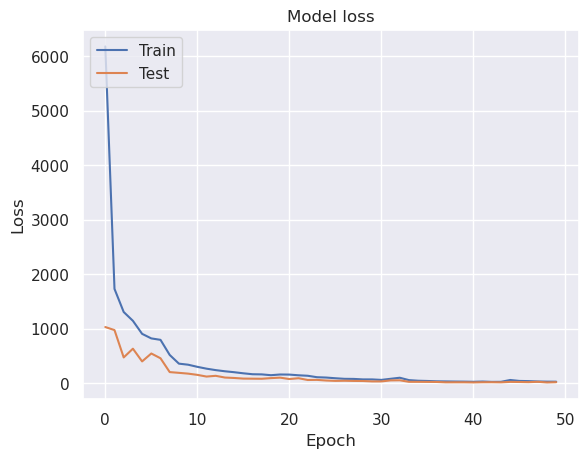

In [ ]:
# Plot loss graph
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Check model parameters
print("\nFirst 5 Learned Parameters:")
for layer in model.layers:
    print("\n",layer.get_weights()[0][:5]),
    #print("\nBias term:",layer.get_weights()[1])


# The loss at the final epoch s;
print("\nLoss at Final Epoch:")
print('\nTraining Loss: ', results.history['loss'][-1])
print('\nValidation Loss:', results.history['val_loss'][-1])

# The percentage difference between the losses observed
if results.history['loss'][-1] != 0 :
    loss_diff  =( results.history['loss'][-1]-results.history['val_loss'][-1] )/results.history['loss'][-1]
    print(f'\nLoss Difference (%):, {loss_diff * 100:.2f} %')


First 5 Learned Parameters:

 [[0.999 0.997 0.999 1.    1.    0.999 1.    0.997 0.999 1.001 0.999 0.999
  0.998 1.001 1.    1.001 1.    0.999 1.    1.    1.    1.    1.    0.999
  1.    0.998 1.001 1.    1.    0.999 1.    1.    1.001 1.002 0.999 1.001
  1.001 1.    1.    1.001 0.999 0.999 0.999 1.    0.999 0.999 0.999 1.
  0.999 1.    1.    1.    1.    1.001 1.    1.    1.    1.    1.    1.
  1.001 0.999 1.    1.   ]
 [0.999 0.997 0.999 1.    1.    0.999 1.    0.997 0.999 1.001 0.999 0.999
  0.998 1.001 1.    1.001 1.    0.999 1.    1.    1.    1.    1.    0.999
  1.    0.998 1.001 1.    1.    0.999 1.    1.    1.001 1.002 0.999 1.001
  1.001 1.    1.    1.001 0.999 0.999 0.999 1.    0.999 0.999 0.999 1.
  0.999 1.    1.    1.    1.    1.001 1.    1.    1.    1.    1.    1.
  1.001 0.999 1.    1.   ]
 [1.    0.997 0.999 1.001 1.    0.999 1.    0.997 0.999 1.001 0.999 0.999
  0.998 1.001 1.    1.001 1.    0.999 1.    1.    1.    1.    1.    0.999
  0.999 0.998 1.001 1.    1.    0.999 1

In [ ]:
# Predictions on train-validation data
train_validation_scores(model,model_type='neuralnet')

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
### Test data evaluation: 

Train Accuracy: 0.4891304347826087 

Train MSE: 0.6478260869565218 

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
### Validation data evaluation: 

Validation Accuracy: 0.4532608695652174 

Validation MSE: 0.6890099243856332 



29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

### Test data set evaluation: 

Accuracy: 0.46956521739130436 

Mean Squared Error (MSE): 0.6891304347826087 

Mean Absolute Error (MAE): 0.5826086956521739 

Precision: [0.    0.203 0.824 0.   ] 

Recall: [0.    0.509 0.465 0.   ] 

F1 Score: [0.    0.291 0.595 0.   ] 



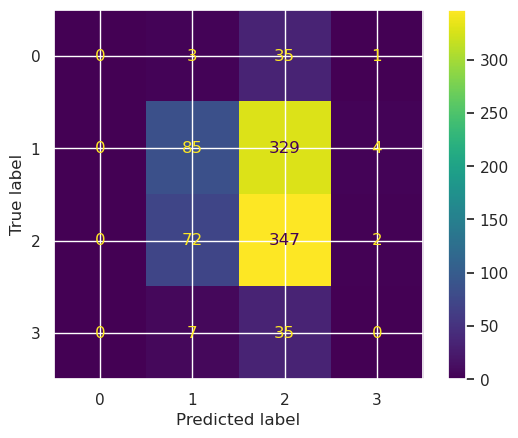

In [ ]:
# Predictions on test data
prediction_scores(model,model_type='neuralnet')